In [71]:
import json
from os.path import normpath, dirname, abspath
import numpy as np
import pandas as pd
import xarray as xr
from lmfit import Model
import lmfit
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as plticker
import natsort

In [29]:
# This will bind the paths from localSettings.json to objects in a class named paths
# usage: paths.<name>
class JSONObject:
    def __init__(self, dict):
        vars(self).update(dict)
with open(normpath(r"./localSettings.json"), "r") as f:
    path_data = f.read()
paths = json.loads(path_data, object_hook=JSONObject)

label_size = 22
plt.rcParams.update(
    {
        "font.size": label_size,
        "legend.title_fontsize": 22,
        "legend.fontsize": 22,
        "axes.labelsize": label_size,
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
        "axes.labelpad": 4,
        "lines.markersize": 10,
        "lines.linewidth": 2,
    }
)

# Default matplotlob colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

CONST_Velocity = 1.986
Nr = range(1,8)
order = np.array([6,5,4,3,2,1])-1

In [30]:
def Read_in_Data (path, dataarray_name_nc, dim3='volt'):
    # Look if we have a .nc file, if not open all the files, create DataArray and save it as .nc
    # NetCDF read in takes 2s, the normal one 40s
    NetCDF = False
    for file in os.listdir(path):
        if file.endswith(dataarray_name_nc):
            NetCDF = True

    if NetCDF:
        data_kalibrierung = xr.open_dataarray(normpath(path+dataarray_name_nc))
    else:
        # Absolute paths to files
        filenames = [normpath(path+files) for files in os.listdir(path)]
        filenames = natsort.natsorted(filenames)
        print('Make sure this is in order!!')
        print(filenames)
        # xarray handles multidimensional arrays easier
        data_kalibrierung = xr.concat(
            [xr.DataArray(
                np.loadtxt(files), 
                # like in a matrix, first dimension 'downwards', then to the 'right side'
                dims=('timestep', 'nr')) 
                for files in filenames],
            dim=(dim3)
        )
        data_kalibrierung.to_dataset(name='Default').to_netcdf(normpath(path+dataarray_name_nc))

    return data_kalibrierung

Kalibrierung

In [31]:
path = paths.Modul3+'Kalibrierung/'
dataarray_name_nc = 'data_kalibrierung.nc'
data_kalibrierung = Read_in_Data(path, dataarray_name_nc)
# kali_mean_old = data_kalibrierung.mean(dim='timestep')

kali_mean = data_kalibrierung.mean(dim='timestep')
kali_std = data_kalibrierung.std(dim='timestep')

voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(kali_mean.min(dim=('volt', 'nr')), kali_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity
D = np.arange(0.5,4.25,0.25)

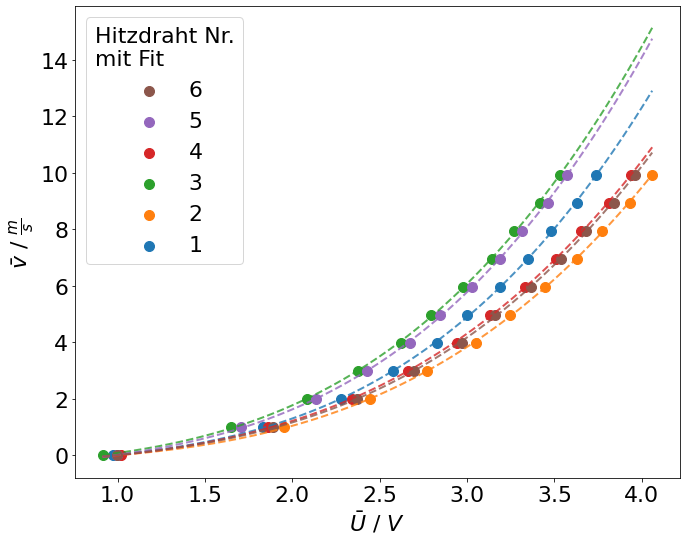

In [32]:
params_vec = list() # Mittel und Klein
default_cycler = cycler(color=colors)
fig, ax = plt.subplots(1,1,figsize=(10,8), tight_layout=True)
for (hitzdraht, hitzdraht_std, i, sty) in zip(kali_mean.T, kali_std.T, Nr, default_cycler):
    ax.scatter(hitzdraht, velocity, label=f'{i}', **sty) 
    # ax.errorbar(hitzdraht, velocity, hitzdraht_std, label=f'{i}', fmt='o', fillstyle='none', markeredgewidth=2)

    # Fitting Polynomial 3rd degree
    model = lmfit.models.PolynomialModel(degree=3)
    params = model.guess(x=hitzdraht, data=velocity) 
    params_vec.append(params)
    result = model.fit(x=hitzdraht, data=velocity, params=params)
    ax.plot(hitzdraht_range,  result.eval(result.params, x=hitzdraht_range), ls='--', alpha=0.8, **sty) 

# print(result.fit_report())

ax.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
ax.set_xlabel(r'$\bar{U}$ / $V$')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Hitzdraht Nr.\nmit Fit')
fig.savefig('Abb/Modul3/Kalibrierung.png')

Nachlauf $\alpha = 50 \degree$ (normal), 3 m/s

In [42]:
path = paths.Modul3+'v3ms_50/'
dataarray_name_nc = 'data_v3ms_50.nc'
data_v3ms_50 = Read_in_Data(path, dataarray_name_nc)
# kali_mean_old = data_kalibrierung.mean(dim='timestep')

v3ms_50_mean = data_v3ms_50.mean(dim='timestep')
v3ms_50_std = data_v3ms_50.std(dim='timestep')

voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(v3ms_50_mean.min(dim=('volt', 'nr')), v3ms_50_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity

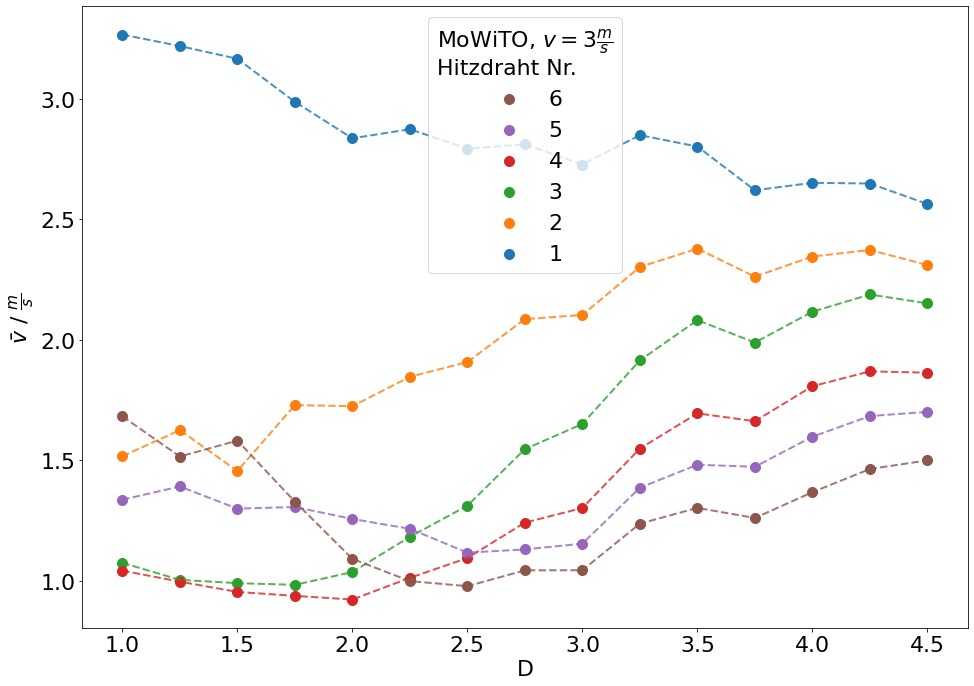

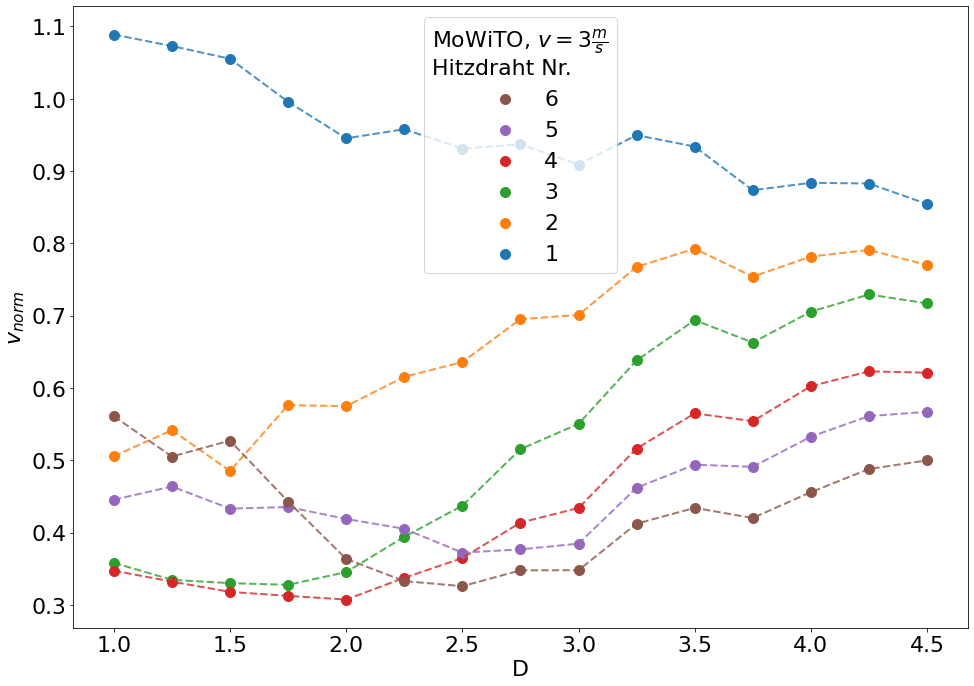

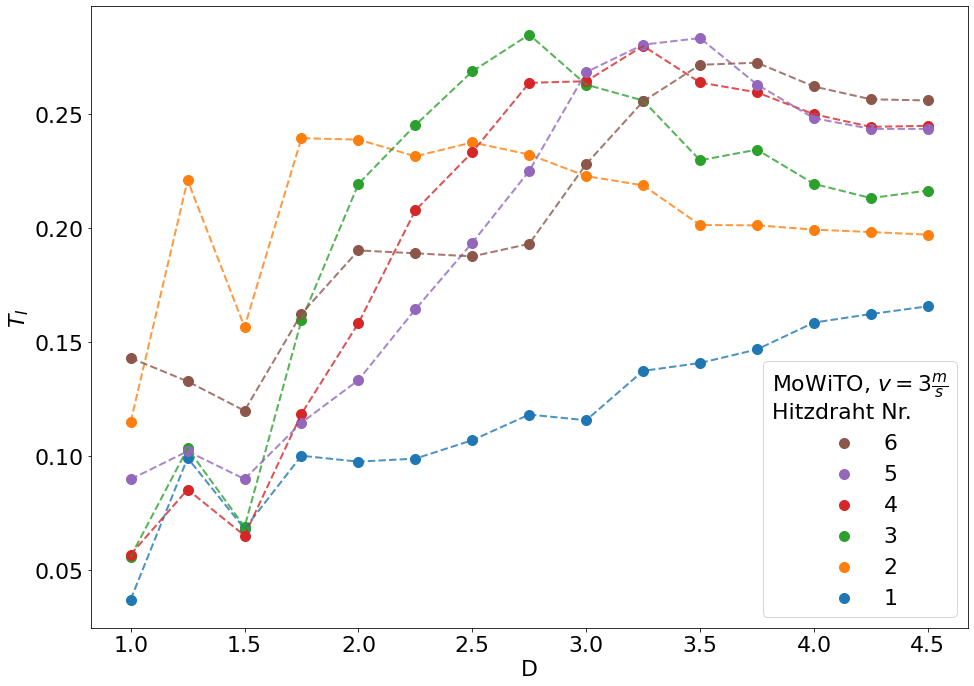

In [43]:
D = np.arange(1.0,4.75,0.25)

fig_mean, ax_mean = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_mean_norm, ax_mean_norm = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
idx = 0
for (hitzdraht, i, sty) in zip(data_v3ms_50.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 

    ax_mean_norm.scatter(D, vel_mean/3, label=f'{i}', **sty) 
    ax_mean_norm.plot(D, vel_mean/3, alpha=0.8, ls='--', **sty) 

    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

# ax_mean.set_ylim(0.45,3.55)
# ax_std.set_ylim(0.15, 0.7)

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $v=3\\frac{m}{s}$\nHitzdraht Nr.', loc='upper center')
fig_mean.savefig('Abb/Modul3/Geschw/mowito_v3_alpha50_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $v=3\\frac{m}{s}$\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul3/Geschw/mowito_v3_alpha50_turb_int.png')

ax_mean_norm.set_xlabel('D')
ax_mean_norm.set_ylabel('$v_{norm}$')
handles, labels = ax_mean_norm.get_legend_handles_labels()
ax_mean_norm.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $v=3\\frac{m}{s}$\nHitzdraht Nr.', loc='upper center')
fig_mean_norm.savefig('Abb/Modul3/Geschw/mowito_v3_alpha50_mean_norm.png')


Nachlauf $\alpha = 50 \degree$ (normal), 6 m/s

In [44]:
path = paths.Modul3+'v6ms_50/'
dataarray_name_nc = 'data_v6ms_50.nc'
data_v6ms_50 = Read_in_Data(path, dataarray_name_nc)
# kali_mean_old = data_kalibrierung.mean(dim='timestep')

v6ms_50_mean = data_v6ms_50.mean(dim='timestep')
v6ms_50_std = data_v6ms_50.std(dim='timestep')

voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(v6ms_50_mean.min(dim=('volt', 'nr')), v6ms_50_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity

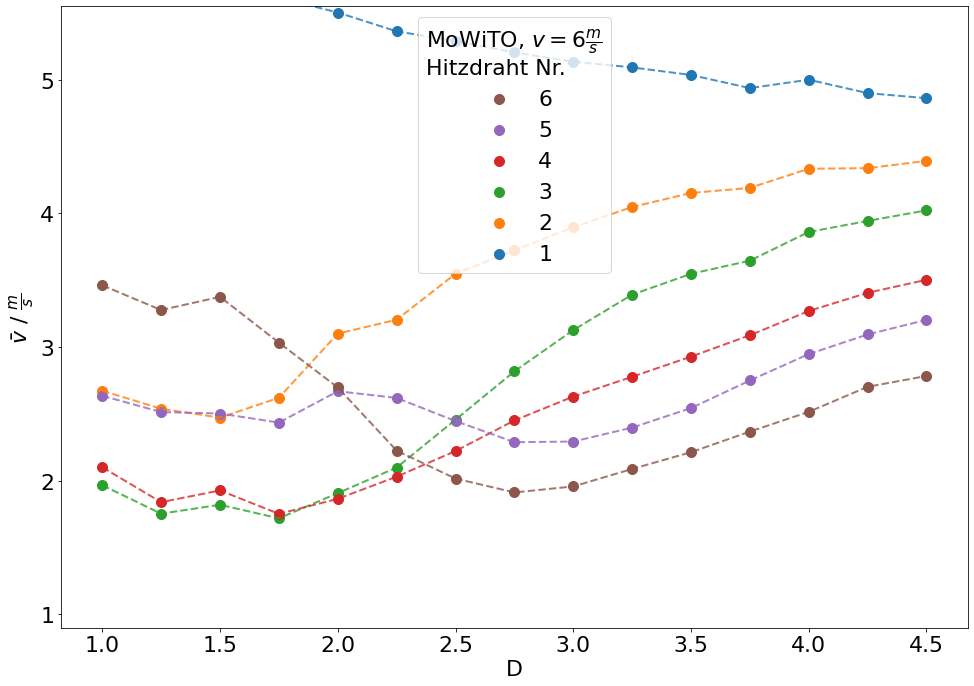

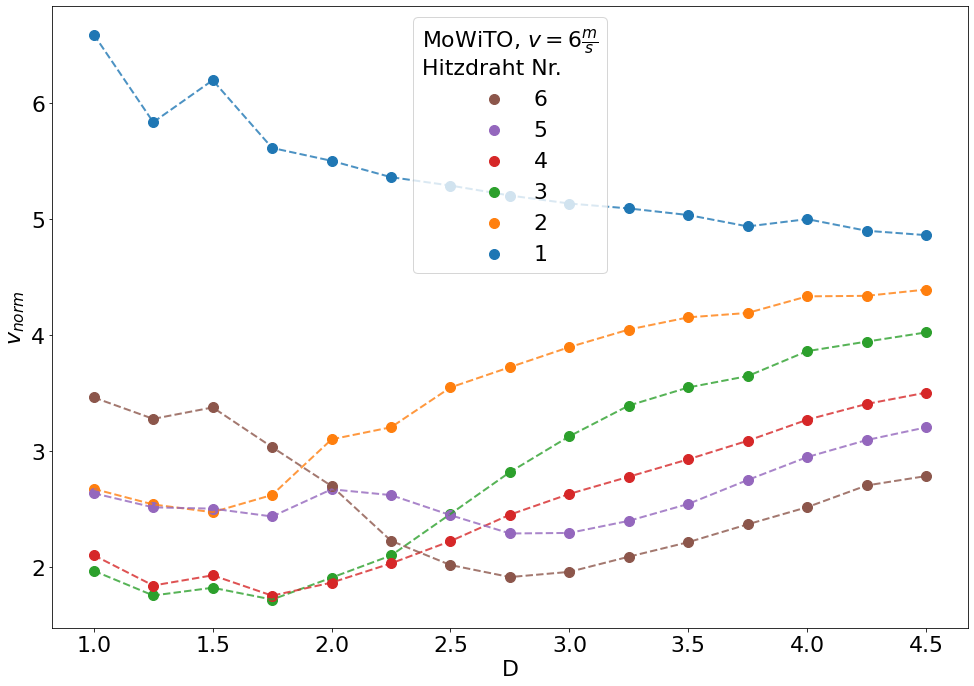

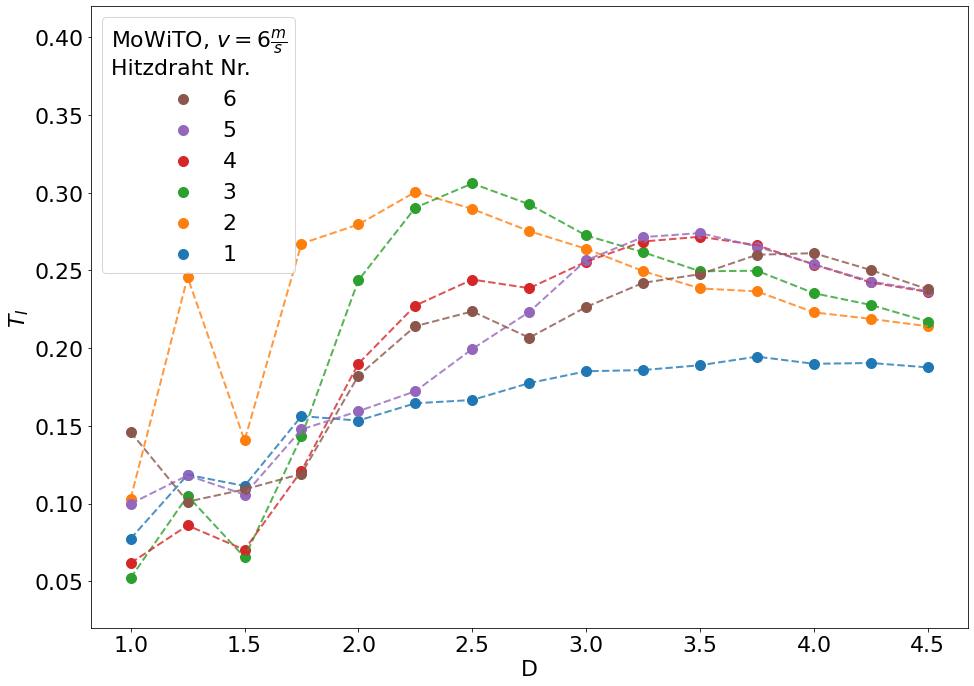

In [56]:
D = np.arange(1.0,4.75,0.25)

fig_mean, ax_mean = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_mean_norm, ax_mean_norm = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
idx = 0
for (hitzdraht, i, sty) in zip(data_v6ms_50.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_mean_norm.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean_norm.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 

    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

# ax_mean.set_ylim(0.45,3.55)
# ax_std.set_ylim(0.15, 0.7)

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $v=6\\frac{m}{s}$\nHitzdraht Nr.', loc='upper center')
fig_mean.savefig('Abb/Modul3/Geschw/mowito_v6_alpha50_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $v=6\\frac{m}{s}$\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul3/Geschw/mowito_v6_alpha50_turb_int.png')

ax_mean_norm.set_xlabel('D')
ax_mean_norm.set_ylabel('$v_{norm}$')
handles, labels = ax_mean_norm.get_legend_handles_labels()
ax_mean_norm.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $v=6\\frac{m}{s}$\nHitzdraht Nr.', loc='upper center')
fig_mean_norm.savefig('Abb/Modul3/Geschw/mowito_v6_alpha50_mean_norm.png')


Andere Pitchwinkel

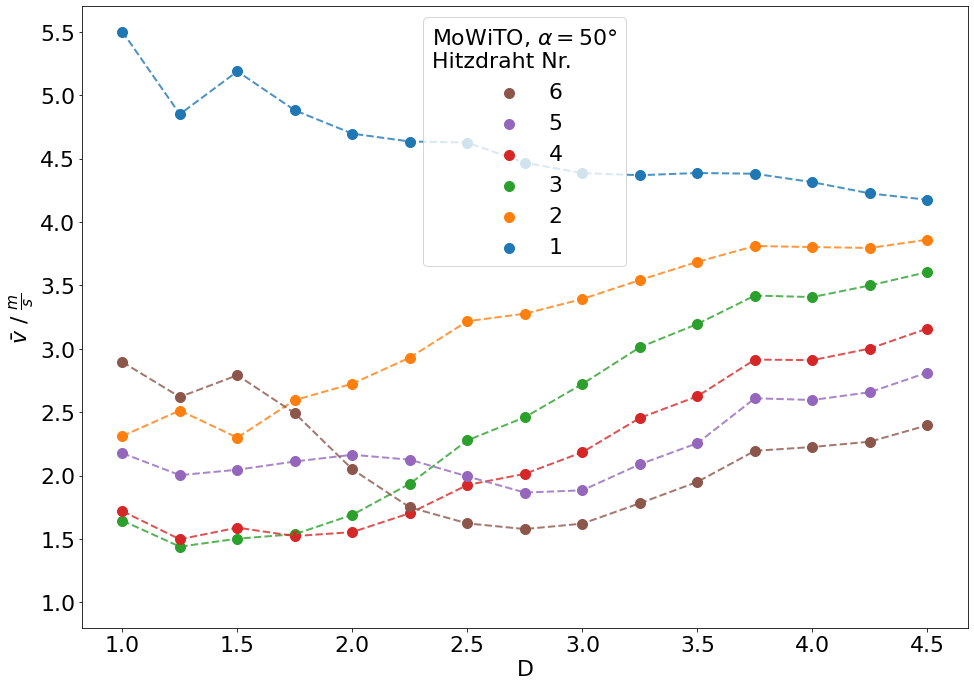

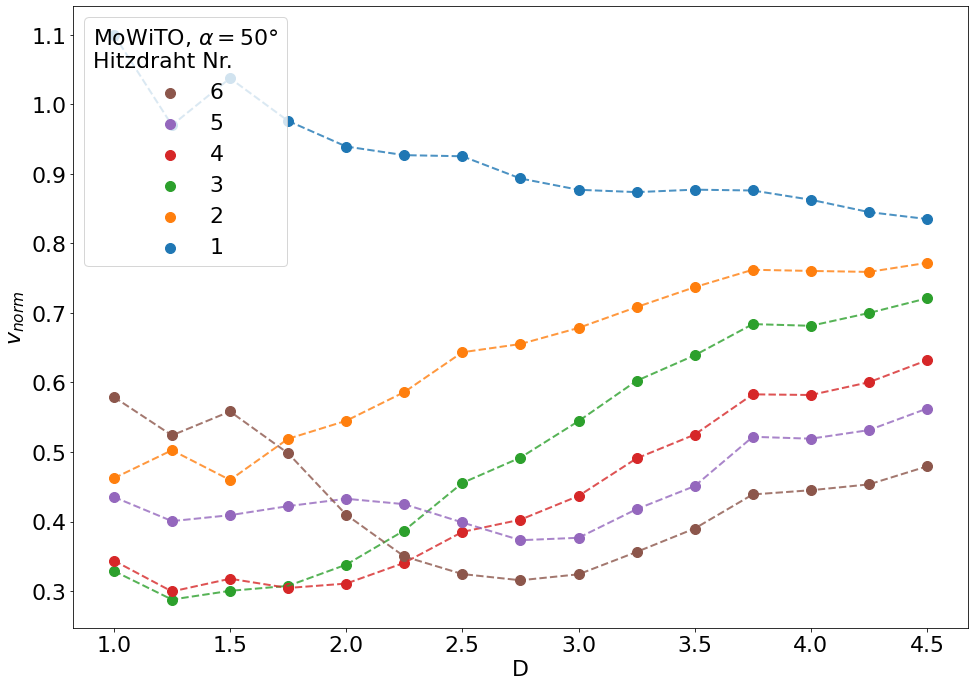

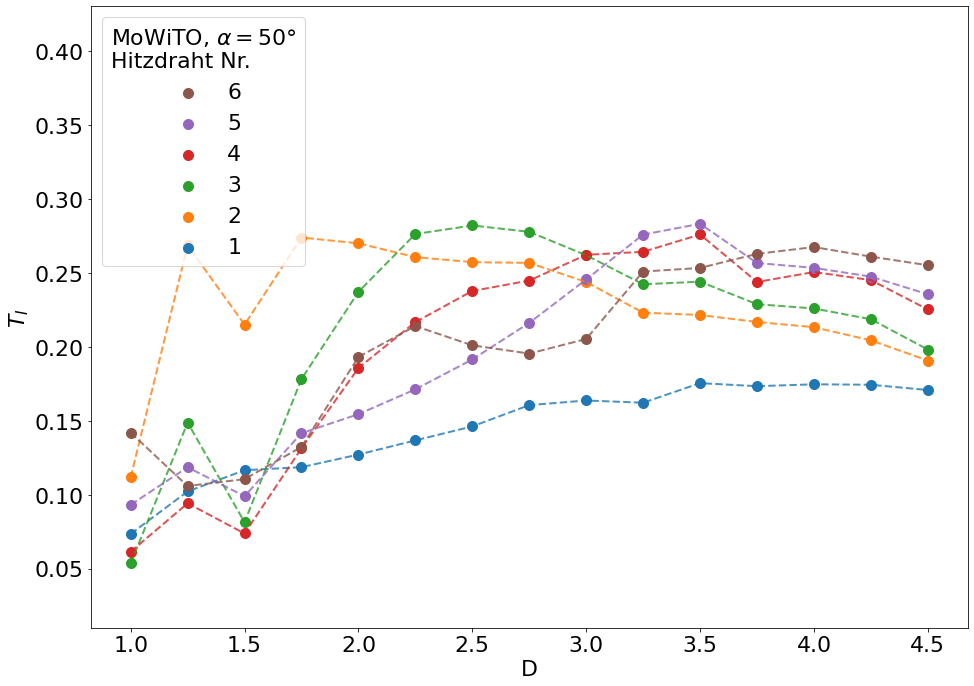

In [80]:
D = np.arange(1.0,4.75,0.25)

fig_mean, ax_mean = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_mean_norm, ax_mean_norm = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(14,10), tight_layout=True)#
idx = 0
for (hitzdraht, i, sty) in zip(data_v5ms_50.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_mean_norm.scatter(D, vel_mean/5, label=f'{i}', **sty) 
    ax_mean_norm.plot(D, vel_mean/5, alpha=0.8, ls='--', **sty) 

    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

ax_mean.set_ylim(0.8,5.7,0.5)
ax_std.set_ylim(0.01,0.43)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax_mean.yaxis.set_major_locator(loc)

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=50\degree$\nHitzdraht Nr.')
fig_mean.savefig('Abb/Modul3/Alphas/mowito_v5_alpha50_mean_2.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=50\degree$\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul3/Alphas/mowito_v5_alpha50_turb_int_2.png')

ax_mean_norm.set_xlabel('D')
ax_mean_norm.set_ylabel('$v_{norm}$')
handles, labels = ax_mean_norm.get_legend_handles_labels()
ax_mean_norm.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=50\degree$\nHitzdraht Nr.')
fig_mean_norm.savefig('Abb/Modul3/Alphas/mowito_v5_alpha50_mean_norm_2.png')

$52 \degree$

In [81]:
path = paths.Modul3+'v5ms_52/'
dataarray_name_nc = 'data_v5ms_52.nc'
data_v5ms_52 = Read_in_Data(path, dataarray_name_nc)
# kali_mean_old = data_kalibrierung.mean(dim='timestep')

v5ms_52_mean = data_v5ms_52.mean(dim='timestep')
v5ms_52_std = data_v5ms_52.std(dim='timestep')

voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(v5ms_52_mean.min(dim=('volt', 'nr')), v5ms_52_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity

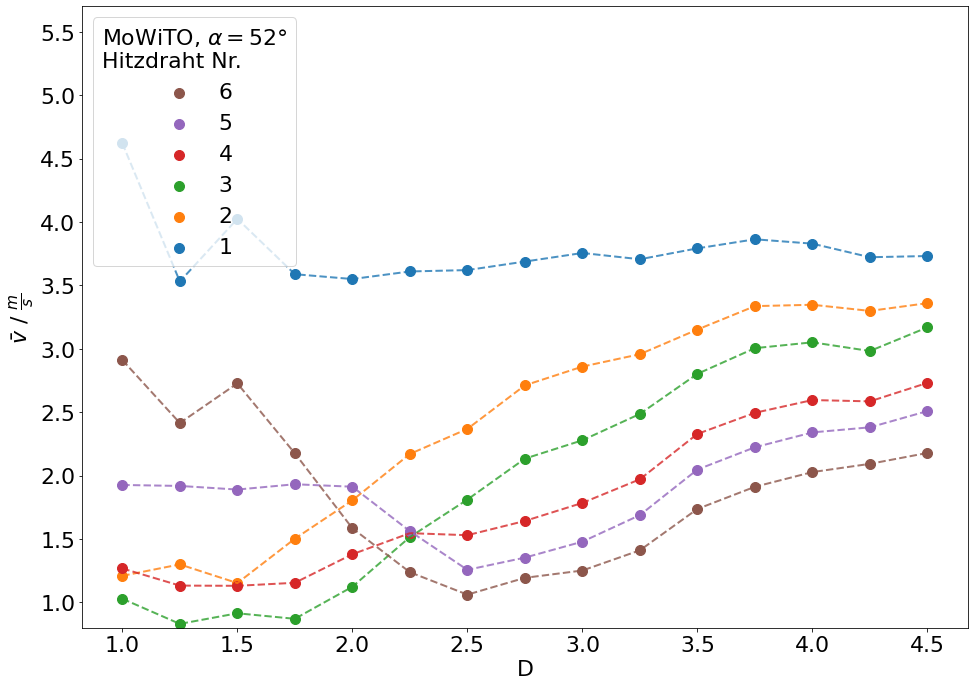

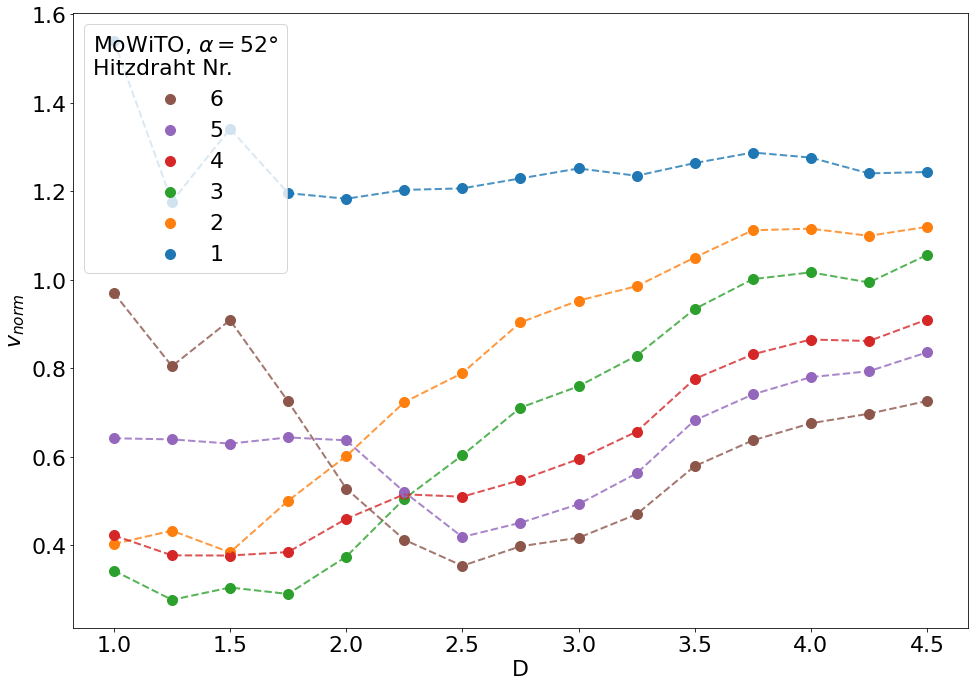

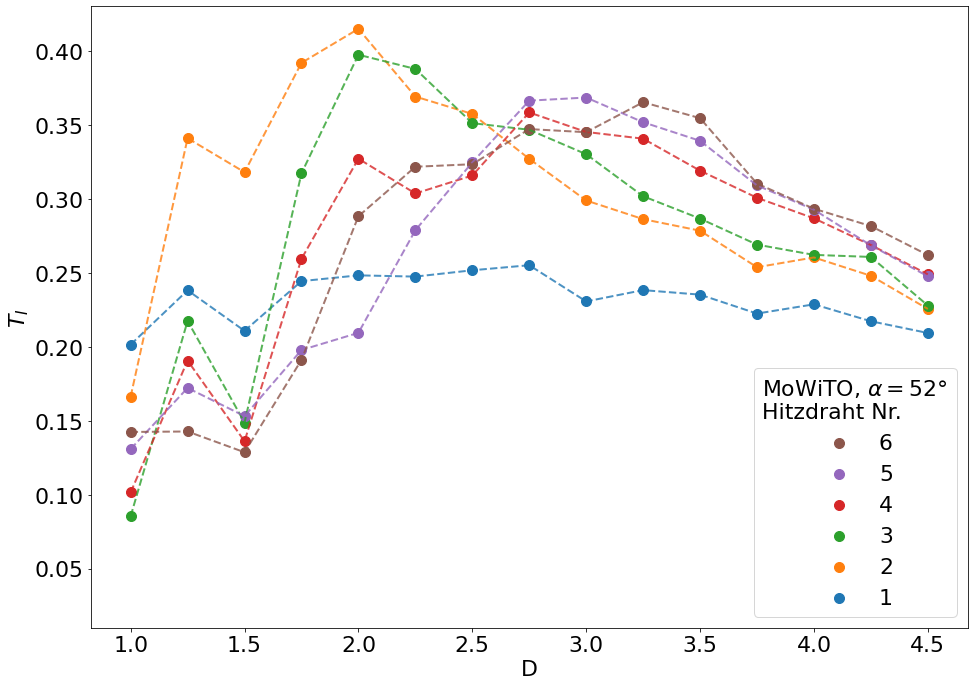

In [82]:
D = np.arange(1.0,4.75,0.25)

fig_mean, ax_mean = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_mean_norm, ax_mean_norm = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(14,10), tight_layout=True)#
idx = 0
for (hitzdraht, i, sty) in zip(data_v5ms_52.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_mean_norm.scatter(D, vel_mean/3, label=f'{i}', **sty) 
    ax_mean_norm.plot(D, vel_mean/3, alpha=0.8, ls='--', **sty) 

    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

ax_mean.set_ylim(0.8,5.7,0.5)
ax_std.set_ylim(0.01,0.43)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax_mean.yaxis.set_major_locator(loc)

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=52\degree$\nHitzdraht Nr.')
fig_mean.savefig('Abb/Modul3/Alphas/mowito_v5_alpha52_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=52\degree$\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul3/Alphas/mowito_v5_alpha52_turb_int.png')

ax_mean_norm.set_xlabel('D')
ax_mean_norm.set_ylabel('$v_{norm}$')
handles, labels = ax_mean_norm.get_legend_handles_labels()
ax_mean_norm.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=52\degree$\nHitzdraht Nr.')
fig_mean_norm.savefig('Abb/Modul3/Alphas/mowito_v5_alpha52_mean_norm.png')

In [83]:
path = paths.Modul3+'v5ms_48/'
dataarray_name_nc = 'data_v5ms_48.nc'
data_v5ms_48 = Read_in_Data(path, dataarray_name_nc)
# kali_mean_old = data_kalibrierung.mean(dim='timestep')

v5ms_48_mean = data_v5ms_48.mean(dim='timestep')
v5ms_48_std = data_v5ms_48.std(dim='timestep')

voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(v5ms_48_mean.min(dim=('volt', 'nr')), v5ms_48_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity

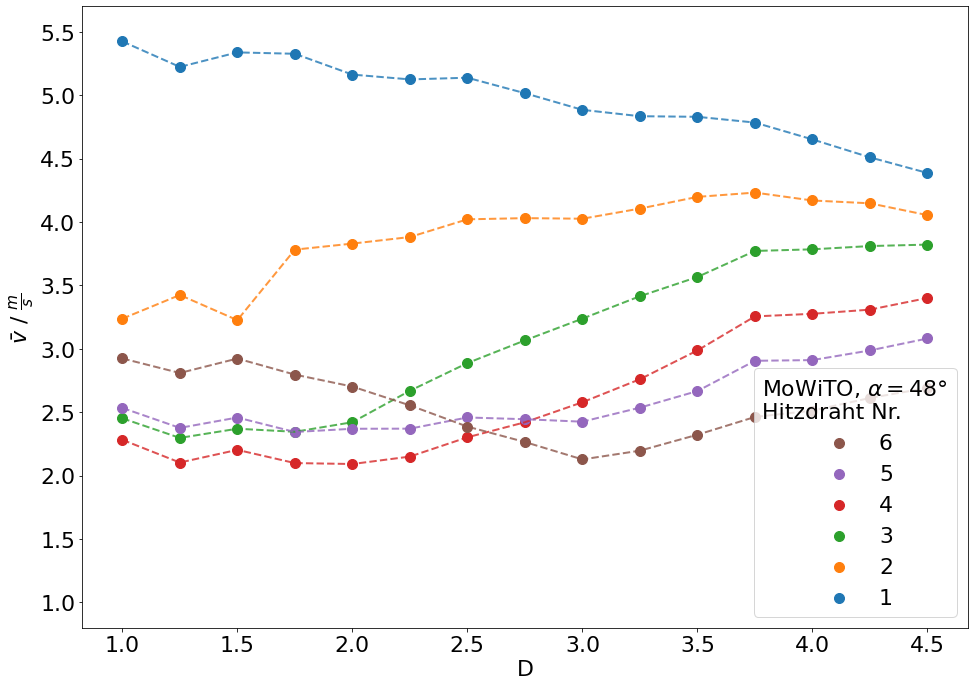

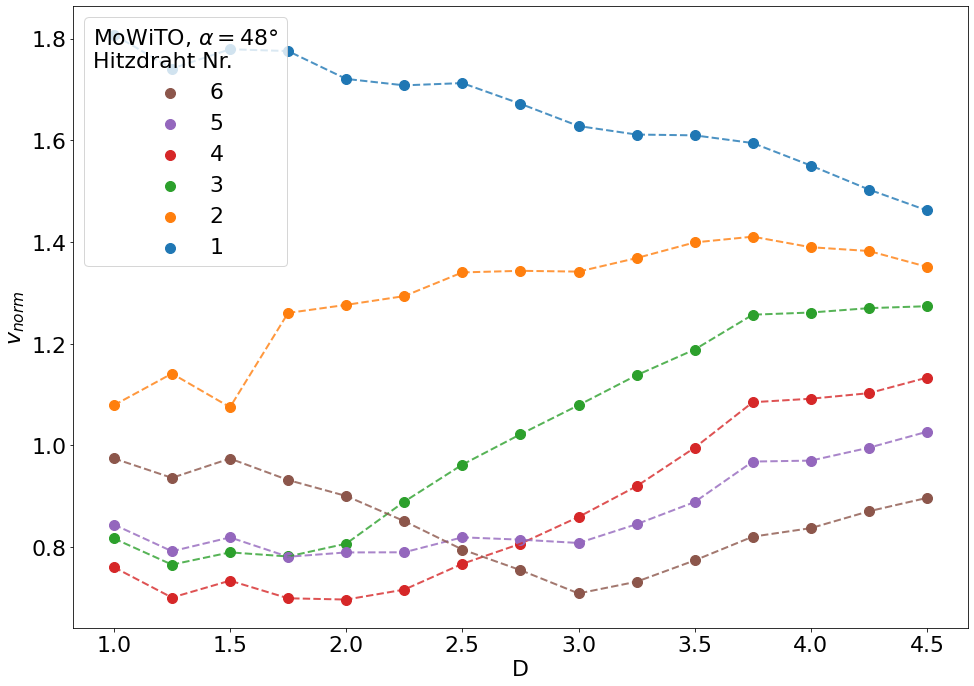

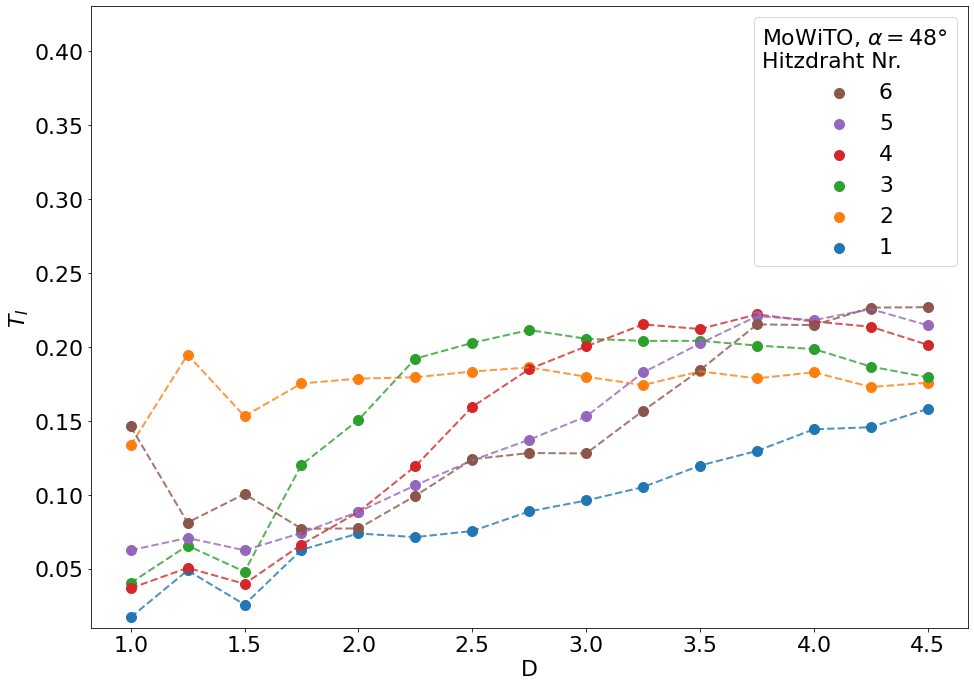

In [84]:
D = np.arange(1.0,4.75,0.25)

fig_mean, ax_mean = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_mean_norm, ax_mean_norm = plt.subplots(1,1, figsize=(14,10), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(14,10), tight_layout=True)#
idx = 0
for (hitzdraht, i, sty) in zip(data_v5ms_48.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_mean_norm.scatter(D, vel_mean/3, label=f'{i}', **sty) 
    ax_mean_norm.plot(D, vel_mean/3, alpha=0.8, ls='--', **sty) 

    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

ax_mean.set_ylim(0.8,5.7,0.5)
ax_std.set_ylim(0.01,0.43)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax_mean.yaxis.set_major_locator(loc)

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=48\degree$\nHitzdraht Nr.')
fig_mean.savefig('Abb/Modul3/Alphas/mowito_v5_alpha48_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=48\degree$\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul3/Alphas/mowito_v5_alpha48_turb_int.png')

ax_mean_norm.set_xlabel('D')
ax_mean_norm.set_ylabel('$v_{norm}$')
handles, labels = ax_mean_norm.get_legend_handles_labels()
ax_mean_norm.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='MoWiTO, $\\alpha=48\degree$\nHitzdraht Nr.')
fig_mean_norm.savefig('Abb/Modul3/Alphas/mowito_v5_alpha48_mean_norm.png')